In [1]:
from utils.data.dataset_ingredient import *
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm
from utils.training import *
from utils.training import evaluate, _Metrics
from models.ingredient import model_ingredient, get_model
from utils.metrics import recall_at_ks_full, fp_fn_eval
import torch
from torch import nn
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform
from fastdist import fastdist

## Re-split dataset into train/pool/test

In [292]:
train_data = open('data/InShop/train.txt').readlines()
# test_data = open('data/Stanford_Online_Products/test.txt').readlines()
test_data = open('data/InShop/test_gallery.txt').readlines() + open('data/InShop/test_query.txt').readlines()

In [162]:
# # split some training into query+testing 
# train_imgs = [x.strip().split(',')[0] for x in train_data]
# train_labels = [x.strip().split(',')[1] for x in train_data]

# # split into testing and query 
# test_imgs = [x.strip().split(',')[0] for x in test_data]
# test_labels = [x.strip().split(',')[1] for x in test_data]

In [293]:
all_data = train_data + test_data
all_imgs = [x.strip().split(',')[0] for x in all_data]
all_labels = [int(x.strip().split(',')[1]) for x in all_data]

In [294]:
# all few-shot classes are included in training
fewshot = {k: Counter(all_labels)[k] for k in Counter(all_labels).keys() if Counter(all_labels)[k] <= 4}

In [295]:
fewshot_class = list(fewshot.keys())
print(len(fewshot_class), len(list(Counter(all_labels).keys())))

3941 7982


In [296]:
train_keep_data = np.asarray(all_data)[np.isin(np.asarray(all_labels), fewshot_class)]
train_imgs = [x.strip().split(',')[0] for x in train_keep_data]
train_labels = [int(x.strip().split(',')[1]) for x in train_keep_data]

In [297]:
train_keep_imgs, train_left_imgs, train_keep_labels, train_left_labels = train_test_split(train_imgs, train_labels, 
                                                                                        test_size=0.4, 
                                                                                        random_state=42, 
#                                                                                         stratify=train_labels  
                                                                                         )


In [298]:
with open('data/InShop/train_small.txt', 'w') as f:
    pass

for j in range(len(train_keep_imgs)):
    with open('data/InShop/train_small.txt', 'a+') as f:
        f.write(train_keep_imgs[j] + ',' + str(train_keep_labels[j]) + '\n')

In [299]:
# split into testing and query 
query_imgs = train_left_imgs
query_labels = train_left_labels
test_imgs = np.asarray(all_imgs)[(~np.isin(np.asarray(all_imgs), train_keep_imgs))&(~np.isin(np.asarray(all_imgs), query_imgs))]
test_labels = np.asarray(all_labels)[(~np.isin(np.asarray(all_imgs), train_keep_imgs))&(~np.isin(np.asarray(all_imgs), query_imgs))]

In [300]:
query_extra_imgs, test_keep_imgs, query_extra_labels, test_keep_labels = train_test_split(test_imgs, test_labels, 
                                                                              test_size=0.5, 
                                                                              random_state=42, 
                                                                              stratify=test_labels,
                                                                             )


In [301]:
with open('data/InShop/pool.txt', 'w') as f:
    pass

for j in range(len(query_imgs)):
    with open('data/InShop//pool.txt', 'a+') as f:
        f.write(query_imgs[j] + ',' + str(query_labels[j]) + '\n')
        
for j in range(len(query_extra_imgs)):
    with open('data/InShop//pool.txt', 'a+') as f:
        f.write(query_extra_imgs[j] + ',' + str(query_extra_labels[j]) + '\n')

In [302]:
with open('data/InShop/test_new.txt', 'w') as f:
    pass

for j in range(len(test_keep_imgs)):
    with open('data/InShop/test_new.txt', 'a+') as f:
        f.write(test_keep_imgs[j] + ',' + str(test_keep_labels[j]) + '\n')

In [308]:
print('Num training: {}'.format(len(open('data/Stanford_Online_Products/train_small.txt').readlines())))
print('Num query: {}'.format(len(open('data/Stanford_Online_Products/pool.txt').readlines())))
print('Num test: {}'.format(len(open('data/Stanford_Online_Products/test_new.txt').readlines())))

Num training: 20080
Num query: 56680
Num test: 43293


## Check class balances

In [303]:
train_data = open('data/InShop/train_small.txt').readlines()
test_data = open('data/InShop/test_new.txt').readlines()
pool_data = open('data/InShop/pool.txt').readlines()

In [304]:
train_classes = [int(x.strip().split(',')[1]) for x in train_data]
test_classes = [int(x.strip().split(',')[1]) for x in test_data]
pool_classes = [int(x.strip().split(',')[1]) for x in pool_data]

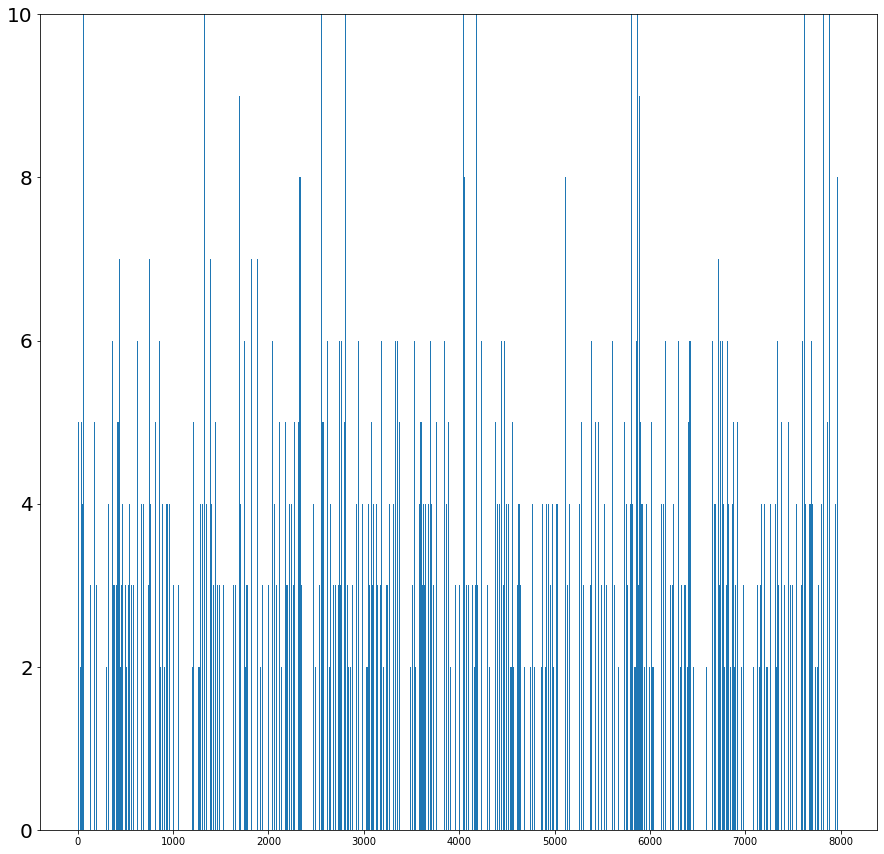

In [307]:
plt.figure(figsize=(15,15))
plt.bar(x=Counter(test_classes).keys(), height=Counter(test_classes).values())
plt.yticks(fontsize=20)
plt.ylim(top=10)
plt.show()

## Load configurations

In [35]:
general_config = data_ingredient.configurations[0]()
data_config = data_ingredient.named_configs['cub']() # experiment's config
# data_config = data_ingredient.named_configs['inshop_vae']() # experiment's config


train_file = data_config['train_file'] if 'train_file' in data_config.keys() else general_config['train_file']
test_file = data_config['test_file'] if 'test_file' in data_config.keys() else general_config['test_file']
pool_file = data_config['pool_file'] if 'pool_file' in data_config.keys() else general_config['pool_file']
sampler = general_config['sampler']
batch_size = general_config['batch_size']
test_batch_size = general_config['test_batch_size']
preload = general_config['preload']
num_workers = general_config['num_workers']
pin_memory = general_config['pin_memory']
scale = general_config['scale']
ratio = general_config['ratio']
recalls = general_config['recalls']

name = data_config['name']
data_path = data_config['data_path']
resize = data_config['resize'] if 'resize' in data_config.keys() else None
rotate = data_config['rotate'] if 'rotate' in data_config.keys() else None
color_jitter = data_config['color_jitter'] if 'color_jitter' in data_config.keys() else None
crop_size = data_config['crop_size'] if 'crop_size' in data_config.keys() else general_config['crop_size']


scale = data_config['scale'] if 'scale' in data_config.keys() else scale
ratio = data_config['ratio'] if 'ratio' in data_config.keys() else ratio
recalls = data_config['recalls'] if 'recalls' in data_config.keys() else recalls


In [36]:
def get_sets(name, data_path, train_file, test_file, pool_file, preload, num_workers):
    train_transform, test_transform = get_transforms(crop_size, 
                                                     scale, ratio, 
                                                     resize, rotate, 
                                                     color_jitter)

    train_lines = read_file(os.path.join(data_path, train_file))
    train_samples = [(os.path.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in train_lines]
    known_classes = [int(line.split(',')[1]) for line in train_lines]
    train_set = ImageDataset(train_samples, transform=train_transform, 
                             preload=preload, num_workers=num_workers)

    query_lines = read_file(os.path.join(data_path, test_file))
    query_samples = [(os.path.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in query_lines]
    query_set = ImageDataset(query_samples, transform=test_transform, preload=preload, num_workers=num_workers)
    gallery_set = None
        
    # test set which only includes novel classes
    query_novel_samples = [(os.path.join(data_path, line.split(',')[0]), int(line.split(',')[1])) \
                               for line in query_lines if int(line.split(',')[1]) not in known_classes]  
    query_novel_set = ImageDataset(query_novel_samples, transform=test_transform, 
                                   preload=preload, num_workers=num_workers)

    # pool set
    pool_lines = read_file(os.path.join(data_path, pool_file))
    pool_samples = [(os.path.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in pool_lines]
    pool_set = ImageDataset(pool_samples, transform=test_transform, preload=preload, num_workers=num_workers)

    return train_set, (query_set, gallery_set, pool_set, query_novel_set)


In [37]:
def get_loaders(batch_size, test_batch_size, num_workers, pin_memory, sampler, recalls,
                num_iterations=None, num_identities=None):
    
    train_set, (query_set, gallery_set, pool_set, query_novel_set) = get_sets(name, data_path, 
                                                             train_file, test_file, pool_file,
                                                             preload, num_workers)

    if sampler == 'random':
        train_sampler = BatchSampler(RandomSampler(train_set), batch_size=batch_size, drop_last=True)
    elif sampler == 'random_id':
        train_sampler = RandomReplacedIdentitySampler(train_set.targets, batch_size, num_identities, num_iterations)
    else:
        raise ValueError('Invalid choice of sampler ({}).'.format(sampler))
    train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_noshuffle = DataLoader(train_set, batch_size=test_batch_size,num_workers=num_workers, pin_memory=pin_memory)
    query_loader = DataLoader(query_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
    gallery_loader = None
    if gallery_set is not None:
        gallery_loader = DataLoader(gallery_set, batch_size=test_batch_size, num_workers=num_workers,
                                    pin_memory=pin_memory)
        
    query_novel_loader = DataLoader(query_novel_set, batch_size=test_batch_size, 
                                    num_workers=num_workers, pin_memory=pin_memory)
    
    # label is not continuous, need this dictionary to map it to continuous integer
    labeldict = {}
    i = 0
    for label in set(train_set.targets):
        if int(label) not in labeldict.keys():
            labeldict[int(label)] = i
            i += 1
            
    for label in set(pool_set.targets):
        if int(label) not in labeldict.keys():
            labeldict[int(label)] = i
            i += 1
            
    for label in set(query_set.targets):
        if int(label) not in labeldict.keys():
            labeldict[int(label)] = i
            i += 1
 
    print(labeldict)
    
    pool_loader = DataLoader(pool_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
    return MetricLoaders(train=train_loader, query=query_loader, pool=pool_loader, gallery=gallery_loader, 
                         train_noshuffle = train_noshuffle,
                         num_classes=len(set(train_set.targets)),
                         labeldict=labeldict,
                         query_novel=query_novel_loader), recalls

In [38]:
loaders, recall_ks = get_loaders(batch_size, test_batch_size, num_workers, pin_memory, sampler, recalls)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 121: 121,

In [33]:
max(loaders.query_novel.dataset.targets)

195

In [335]:
len(loaders.train.dataset)

5396

In [ ]:
len(loaders.pool.dataset)

In [17]:
len(loaders.query.dataset)

2594

In [336]:
loaders.num_classes

98

In [ ]:
recall_ks

In [39]:
arch = 'resnet50'
pretrained = True  # use a pretrained model from torchvision
num_features = 2048 # dimensionality of the features produced by the feature extractor
dropout = 0.5
norm_layer = None  # use a normalization layer (batchnorm or layernorm) for the features
# norm_layer = 'batch'
remap = False  # remap features through a linear layer
detach = False  # detach features before feeding to the classification layer. Prevents training of the feature extractor with cross-entropy.
normalize = False  # normalize the features
set_bn_eval = True  # set bn in eval mode even in training
normalize_weight = False  # normalize the weights of the classification layer

model = get_model(loaders.num_classes, arch, pretrained, num_features, 
                  norm_layer, detach, remap, normalize, normalize_weight,
                  set_bn_eval, dropout)

In [43]:
model.load_state_dict(torch.load('checkpoints/resnet50_cub.pt'))
model.to('cuda')

ResNet(
  (norm_layer): Identity()
  (remap): Identity()
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=2048, out_features=100, bias=True)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [29]:
evaluate(model, loaders.query_novel, recall=recall_ks)

_Metrics(loss=None, accuracy=0.0, recall={'l2': {1: 80.55, 2: 87.87, 4: 92.27, 8: 95.63, 16: 97.65, 32: 98.84}, 'cosine': {1: 81.49, 2: 88.2, 4: 93.17, 8: 96.3, 16: 98.06, 32: 98.99}})

## Threshold selection using training data (query within training)

In [331]:
def evaluate_full(model: nn.Module,
             query_loader: DataLoader,
             gallery_loader: Optional[DataLoader] = None,
             xent: bool = False,
             recall: Optional[List[int]] = None,
             threshold_ls: Optional[List[float]] = None) -> _Metrics:
    
    model.eval()
    device = next(model.parameters()).device
    to_device = lambda x: x.to(device, non_blocking=True)
    all_query_labels = []
    all_query_features = []
    all_gallery_features = None
    all_gallery_labels = None
    xent_losses = []
    all_predictions = []

    with torch.no_grad():
        for batch, labels, _ in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
            batch, labels = map(to_device, (batch, labels))
            logits, features = model(batch)

            all_query_labels.append(labels)
            if recall is not None:
                all_query_features.append(features)
            if xent:
                xent_losses.append(F.cross_entropy(logits, labels, reduction='none'))
            all_predictions.append(logits.argmax(1))

        torch.cuda.empty_cache()

        all_query_labels = torch.cat(all_query_labels, 0)
        if recall is not None:
            all_query_features = torch.cat(all_query_features, 0)
            recall_function = partial(
                recall_at_ks_full, query_features=all_query_features, query_labels=all_query_labels, ks=recall,
                gallery_features=all_gallery_features, gallery_labels=all_gallery_labels
            )
            recalls = {}
            precisions = {}
            for ts in threshold_ls:
                recalls['cosine_'+str(ts)], precisions['cosine_'+str(ts)] = recall_function(cosine=True, threshold=ts)

    return recalls, precisions

In [332]:
recall_func, precision_func = evaluate_full(model, loaders.train, recall=[1, 3, 5, 10], 
                                            threshold_ls=np.arange(0.0, 0.9, 0.02))

In [334]:
for ts in np.arange(0.0, 0.9, 0.02):
    recall =  np.mean([np.mean(recall_func['cosine_{}'.format(ts)][i]) for i in [1,3,5,10]])
    precision = np.mean([np.mean(precision_func['cosine_{}'.format(ts)][i]) for i in [1,3,5,10]])
#     print('Threshold {:.2f}'.format(ts), Precision {}'.format(recall, precision))
    print(precision)
#     print(recall)

0.9111759193516629
0.9111759193516629
0.9111759193516629
0.9111759193516629
0.9111759193516629
0.9111759193516629
0.9111759193516629
0.9111759193516629
0.9111759193516629
0.9111759193516629
0.9111821195831478
0.9111573184401998
0.9111578351290273
0.9111515055827086
0.9111495307014285
0.9111227516694406
0.9111134442101302
0.9108969667823473
0.911276610887253
0.9107601638277227
0.9110273502456241
0.9092185190107489
0.9050053215467948
0.8987656140924484
0.8902610184138525
0.8734260722924937
0.8537864242437783
0.8294577853718488
0.7910799452476268
0.7491892061843327
0.6976094531589049
0.6356483661559511
0.5629665690713394
0.4795412453330218
0.4019329534420133
0.3263567047095337
0.24346859099997636
0.16617334339226184
0.10732015782836661
0.06800468874937764
0.03366511701234608
0.013391612533689866
0.006137813951236101
0.002417933893808402
0.0007439732217254465


## Get FP, FN

- What are the FPs, FNs from pooled set?

In [41]:
query_loader = loaders.pool # unlabelled pool
gallery_loader = loaders.train_noshuffle # train loader with no shuffling
recall = recall_ks # TOchange
ts = {'cub':0.64, 'cars':0.4, 'sop':0.5, 'inshop':0.52}['cub'] # TOchange
device = 'cuda'
to_device = lambda x: x.to(device, non_blocking=True)

In [44]:
model.eval()

all_query_labels = []
all_query_features = []
all_predictions = []

with torch.no_grad():
    for batch, labels, _ in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
        batch, labels = map(to_device, (batch, labels))
        logits, features = model(batch)

        all_query_labels.append(labels)
        all_query_features.append(features)
        all_predictions.append(logits.argmax(1))

torch.cuda.empty_cache()
all_query_labels = torch.cat(all_query_labels, 0)
all_query_features = torch.cat(all_query_features, 0)

RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 11.78 GiB total capacity; 1.14 GiB already allocated; 540.69 MiB free; 1.17 GiB reserved in total by PyTorch)

In [ ]:
all_gallery_features = []
all_gallery_labels = []

with torch.no_grad():
    for batch, labels, _ in tqdm(gallery_loader, desc='Extracting gallery features', leave=False, ncols=80):
        batch, labels = map(to_device, (batch, labels))
        features = model(batch)[1]

        all_gallery_labels.append(labels)
        all_gallery_features.append(features)

all_gallery_labels = torch.cat(all_gallery_labels, 0)
all_gallery_features = torch.cat(all_gallery_features, 0)

In [ ]:
set([x.item() for x in all_query_labels]) - set([x.item() for x in all_gallery_labels])

In [ ]:
torch.save(all_query_features, 'checkpoints/cub_query_feat.pt')
torch.save(all_query_labels, 'checkpoints/cub_query_label.pt')
torch.save(all_gallery_features, 'checkpoints/cub_gallery_feat.pt') # or train feat
torch.save(all_gallery_labels, 'checkpoints/cub_gallery_label.pt') # or train label

In [ ]:
all_gallery_features = torch.load('checkpoints/inshop_gallery_feat.pt')
all_gallery_labels = torch.load('checkpoints/inshop_gallery_label.pt') # or train label
all_query_labels = torch.load('checkpoints/inshop_query_label.pt')
all_query_features = torch.load('checkpoints/inshop_query_feat.pt')

In [ ]:
recall_function = partial(
    fp_fn_eval, query_features=all_query_features, query_labels=all_query_labels, ks=recall,
    gallery_features=all_gallery_features, gallery_labels=all_gallery_labels
)
fns, fps = recall_function(cosine=True, threshold=ts)

In [ ]:
fn_samples = np.asarray(query_loader.dataset.samples)[np.where(fns == True)[0]]
fp_samples = np.asarray(query_loader.dataset.samples)[np.where(fps == True)[0]]

In [ ]:
fn_query_features = np.asarray(all_query_features)[np.where(fns == True)[0]]
fp_query_features = np.asarray(all_query_features)[np.where(fps == True)[0]]
fn_query_labels = np.asarray(all_query_labels)[np.where(fns == True)[0]]
fp_query_labels = np.asarray(all_query_labels)[np.where(fps == True)[0]]

normal_query_features = np.asarray(all_query_features)[np.where((fps == False) & (fns == False))[0]]

In [ ]:
assert len(fn_query_features) + len(fp_query_features) + len(normal_query_features) == len(query_loader.dataset.samples)

- Can we detect them by looking at distance to training classes' centroid ?

In [ ]:
# M = torch.zeros(max(all_gallery_labels.numpy())+1, len(all_gallery_features))
# M[all_gallery_labels, torch.arange(all_gallery_features.shape[0])] = 1 # one-hot map
# M = torch.nn.functional.normalize(M, p=1, dim=1) # normalize to have each label of sum 1
# centroids = torch.mm(M, all_gallery_features) # mean for each label
# centroids = F.normalize(centroids, p=2, dim=1).numpy()

In [ ]:
# full_M = torch.zeros(max(all_gallery_labels.numpy())+1, len(all_gallery_features))
# full_M[all_gallery_labels, torch.arange(all_gallery_features.shape[0])] = 1 # one-hot map
# each_centroids = torch.mm(full_M.T, torch.from_numpy(centroids)) # centroids for each obs

In [ ]:
# covs = []
# mus = []

# for label in tqdm(set(all_gallery_labels.numpy())):
    
#     select_gallery_features = all_gallery_features[torch.where(all_gallery_labels == label)[0]]
#     select_centroids = each_centroids[torch.where(all_gallery_labels == label)[0]]
    
#     cov = np.cov(select_gallery_features.numpy(), rowvar=False)
#     covs.append(cov)
#     mus.append(select_centroids[0].numpy())

In [ ]:
# mus = np.asarray(mus)
# covs = np.asarray(covs)

- Normal query to centroids

In [ ]:
# Mahan distance
# query2gallery = []
# for i in tqdm(range(len(mus))):
#     dist = np.dot(np.dot((normal_query_features-mus[i][None, ...]), np.linalg.pinv(covs[i])), 
#                          (normal_query_features-mus[i][None, ...]).T)
#     dist = dist.diagonal()
#     query2gallery.append(dist)

# query2gallery = np.asarray(query2gallery)
# query2gallery = query2gallery.min(0) # distance to nearest centroid

In [ ]:
# Max, Margin to centroids
# normal_query_features = F.normalize(torch.from_numpy(normal_query_features), p=2, dim=1).numpy()
# dist = np.dot(normal_query_features, centroids.T)
# query2gallery = dist.max(0)
# ind = np.argsort(dist, axis=1)
# sorted_dist = np.take_along_axis(dist, ind, axis=1)
# margin_query2gallery = sorted_dist[:, -1] - sorted_dist[:, -2]

- Mutual information

$
\begin{equation} \label{eq1}
\begin{split}
& I(Y_{train} \cup Y_{selected} ; \hat{Z}_{train} \cup \hat{Z}_{selected})  \\
& \approx I(Y_{train} \cup \hat{Y}_{selected} ; \hat{Z}_{train} \cup \hat{Z}_{selected}) \\
& = H(\hat{Z}_{train} \cup \hat{Z}_{selected}) - H(\hat{Z}_{train} \cup \hat{Z}_{selected} | Y_{train} \cup \hat{Y}_{selected}) \\
& = H(\hat{Z}_{train} \cup \hat{Z}_{selected}) - \sum_{\hat{y}}{\sum_{y}{H(\hat{Z}_{train} \cup \hat{Z}_{selected} | Y = y, \hat{Y} = \hat{y}) p(y) p(\hat{y})}} \\
& \approx \frac{d}{(N'-1)N'} \sum_{i=1}^{N+1}{\sum_{j=1}^{N+1}{logD_{ij}^2}} - \sum_{\hat{y}}{\sum_{y}[{ \frac{d}{(S'_{y}-1)S'_{y}}\sum_{i=1}^{y_i=y}{\sum_{j=1}^{y_j=y}{logD_{ij}^2}}] p(y) p(\hat{y})}} \\ \\
& \text{where } \quad N' = N + 1 \text{ (assume one sample is selected}) \\
& \text{where } \quad S_k = \sum_i{\mathbb{1}(y_i = k)} \\
& \text{where } \quad S'_k = \sum_i{\mathbb{1}(y_i = k)} + 1 \text{ (assume one sample is selected}) \\
& \text{where } \quad p_{\hat{y}}(k) = \frac{exp(z_i^Tc_k)}{\sum_{j}{exp(z_i^Tc_j)}} \\
& \text{where } \quad p_y(k) = \frac{S_k}{N}
\end{split}
\end{equation}
$

In [ ]:
# # compute similarity matrix
# z_train = F.normalize(all_gallery_features, p=2, dim=1).numpy()
# z_pool = F.normalize(all_query_features, p=2, dim=1).numpy()
# Sij = 2 - 2 * np.dot(z_train, z_pool.T) # 

# # empirical estimate of p(y) estimated from training set
# (unique, counts) = np.unique(all_gallery_labels, return_counts=True)
# py = counts / np.sum(counts)

# # predicted distribution of p(yhat) for each unlabelled data
# # M = torch.zeros(max(all_gallery_labels.numpy())+1, len(z_train))
# M = torch.zeros(len(unique), len(z_train))
# M[np.asarray([np.where(unique==x.item())[0].item() for x in all_gallery_labels]), torch.arange(z_train.shape[0])] = 1 # one-hot map
# M = torch.nn.functional.normalize(M, p=1, dim=1) # normalize to have each label of sum 1
# centroids = torch.mm(M, torch.from_numpy(z_train)) # mean for each label
# centroids = F.normalize(centroids, p=2, dim=1).numpy() # should normalize otherwise experience overflow problem

# zc = np.dot(z_pool, centroids.T)
# temperature = 1
# pyhat = np.exp(zc / temperature) / np.sum(np.exp(zc / temperature), axis=1, keepdims=True)

# # compute entropy of Z
# Dij = Sij # take distance between THIS example w.r.t gallery set
# d = z_train.shape[1]
# Hz_s = np.sum(np.log(Dij), axis=0) * d / (len(z_train)*(len(z_train)+1))

# # compute conditional entropy of Z|Y
# # M = np.zeros((max(all_gallery_labels.numpy())+1, len(z_train)))
# M = np.zeros((len(unique), len(z_train)))
# M[np.asarray([np.where(unique==x.item())[0].item() for x in all_gallery_labels]), np.arange(z_train.shape[0])] = 1 # one-hot map
# category_sum = np.dot(M, np.log(Dij))
# category_Hz = category_sum * d * (1/((counts+1) * len(z_train))).reshape(-1, 1)

# cond_Hz = np.dot(category_Hz.T, pyhat.T) 
# cond_Hz_s = cond_Hz.diagonal()

# # get fn, fp, normal corresponding entries
# normal_Hz = np.asarray(Hz_s)[np.where((fps == False) & (fns == False))[0]]
# fp_Hz = np.asarray(Hz_s)[np.where((fps == True))[0]]
# fn_Hz = np.asarray(Hz_s)[np.where((fns == True))[0]]

# normal_Hz_cond = np.asarray(cond_Hz_s)[np.where((fps == False) & (fns == False))[0]]
# fp_Hz_cond = np.asarray(cond_Hz_s)[np.where((fps == True))[0]]
# fn_Hz_cond = np.asarray(cond_Hz_s)[np.where((fns == True))[0]]

# normal_info = normal_Hz - normal_Hz_cond
# fp_info = fp_Hz - fp_Hz_cond
# fn_info = fn_Hz - fn_Hz_cond

# plt.hist(fn_Hz, label='FN', bins=50, alpha=0.5)
# plt.hist(normal_Hz, label='Normal', bins=50, alpha=0.5)
# plt.hist(fp_Hz , label='FP', bins=50, alpha=0.5)
# plt.legend()
# plt.show()

# plt.hist(fn_Hz_cond, label='FN', bins=50, alpha=0.5)
# plt.hist(normal_Hz_cond, label='Normal', bins=50, alpha=0.5)
# plt.hist(fp_Hz_cond , label='FP', bins=50, alpha=0.5)
# plt.legend()
# plt.show()

# plt.hist(fn_info, label='FN', bins=50, alpha=0.5)
# plt.hist(normal_info, label='Normal', bins=50, alpha=0.5)
# plt.hist(fp_info , label='FP', bins=50, alpha=0.5)
# plt.legend()
# plt.show()

- FN query to centroids

In [ ]:
# Mahan distance
# fn_query2gallery = []
# for i in tqdm(range(len(mus))):
#     dist = np.dot(np.dot((fn_query_features-mus[i][None, ...]), np.linalg.pinv(covs[i])), 
#                          (fn_query_features-mus[i][None, ...]).T)
#     dist = dist.diagonal()
#     fn_query2gallery.append(dist)
# fn_query2gallery = np.asarray(fn_query2gallery)
# fn_query2gallery = fn_query2gallery.min(0)

In [ ]:
# Max, Margin to centroids
# fn_query_features = F.normalize(torch.from_numpy(fn_query_features), p=2, dim=1).numpy()
# dist = np.dot(fn_query_features, centroids.T)
# fn_query2gallery = dist.max(0)
# ind = np.argsort(dist, axis=1)
# sorted_dist = np.take_along_axis(dist, ind, axis=1)
# fn_margin_query2gallery = sorted_dist[:, -1] - sorted_dist[:, -2]

- FP query to centroids

In [ ]:
# Mahan distance
# fp_query2gallery = []
# for i in tqdm(range(len(mus))):
#     dist = np.dot(np.dot((fp_query_features-mus[i][None, ...]), np.linalg.pinv(covs[i])), 
#                          (fp_query_features-mus[i][None, ...]).T)
#     dist = dist.diagonal()
#     fp_query2gallery.append(dist)
# fp_query2gallery = np.asarray(fp_query2gallery)
# fp_query2gallery = fp_query2gallery.min(0)

In [ ]:
# Max, Margin to centroids
# fp_query_features = F.normalize(torch.from_numpy(fp_query_features), p=2, dim=1).numpy()
# dist = np.dot(fp_query_features, centroids.T)
# fp_query2gallery = dist.max(0)
# ind = np.argsort(dist, axis=1)
# sorted_dist = np.take_along_axis(dist, ind, axis=1)
# fp_margin_query2gallery = sorted_dist[:, -1] - sorted_dist[:, -2]

In [ ]:
plt.hist(fn_query2gallery, label='FN', bins=50, alpha=0.5)
plt.hist(query2gallery, label='Normal', bins=50, alpha=0.5)
plt.hist(fp_query2gallery, label='FP', bins=50, alpha=0.5)
plt.legend()
plt.show()

In [ ]:
plt.hist(fn_query2gallery, label='FN', bins=50, alpha=0.5)
plt.hist(query2gallery, label='Normal', bins=50, alpha=0.5)
plt.hist(fp_query2gallery, label='FP', bins=50, alpha=0.5)
plt.legend()
plt.show()

In [ ]:
plt.hist(fn_margin_query2gallery, label='FN', bins=50, alpha=0.5)
plt.hist(margin_query2gallery, label='Normal', bins=50, alpha=0.5)
plt.hist(fp_margin_query2gallery, label='FP', bins=50, alpha=0.5)
plt.legend()
plt.show()

- Can we detect through reconstruction error ?

In [ ]:
from models.vae_ingredient import model_ingredient, get_model
in_channels = 3
latent_dim = 512
arch = 'AE'

encoder_model = get_model(arch, in_channels, latent_dim)

In [ ]:
encoder_model.load_state_dict(torch.load('checkpoints/AE_sop_vae.pt'))
encoder_model.to(device)

In [ ]:
all_reconstructed_error = torch.tensor([])
with torch.no_grad():
    for batch, labels, _ in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
        batch, labels = map(to_device, (batch, labels))
        z, _, reconstructed = encoder_model(batch)
        reconstructed_error = F.binary_cross_entropy(reconstructed, batch, reduction='none').mean(1).mean(1).mean(1)
        
        print(reconstructed_error.shape)
        all_reconstructed_error = torch.cat((all_reconstructed_error, reconstructed_error.detach().cpu()), dim=0)


In [ ]:
fn_reconstructed_error = np.asarray(all_reconstructed_error)[np.where(fns == True)[0]]
fp_reconstructed_error = np.asarray(all_reconstructed_error)[np.where(fps == True)[0]]
normal_reconstructed_error = np.asarray(all_reconstructed_error)[np.where((fps == False) & (fns == False))[0]]

In [ ]:
train_reconstructed_error = torch.tensor([])
with torch.no_grad():
    for batch, labels, _ in tqdm(loaders.train_noshuffle, desc='Extracting query features', leave=False, ncols=80):
        batch, labels = map(to_device, (batch, labels))
        z, _, reconstructed = encoder_model(batch)
        reconstructed_error = F.binary_cross_entropy(reconstructed, batch, reduction='none').mean(1).mean(1).mean(1)
        print(reconstructed_error.shape)
        train_reconstructed_error = torch.cat((all_reconstructed_error, reconstructed_error.detach().cpu()), dim=0)


In [ ]:
plt.hist(train_reconstructed_error.numpy(), bins=50, label='Training', alpha=0.3)
plt.hist(fn_reconstructed_error, bins=50, label='FN', alpha=0.7)
plt.hist(fp_reconstructed_error, bins=50, label='FP', alpha=0.7)
plt.hist(normal_reconstructed_error, bins=50, label='Normal', alpha=0.7)

plt.legend()
plt.show()